In [ ]:
#default_exp wave_detection

Decoding ./data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0
(outputting one image for every 2 video frames)
300


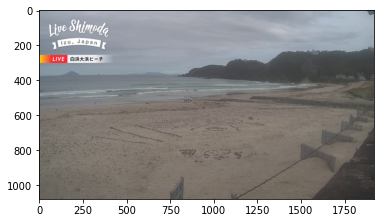

In [ ]:
from matplotlib import pyplot as plt
from surfbreak.load_videos import decode_frame_sequence

frames = decode_frame_sequence('./data/shirahama_1590387334_SURF-93cm.ts', duration_s=10, start_s=100, RGB=True,
                               one_image_per_n_frames=2)
print(len(frames))
im = frames[0]
plt.imshow(im)

In [ ]:
import cv2
import numpy as np

greyscale_cube = np.dstack([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in frames])
greyscale_cube.shape

(1080, 1920, 300)

In [ ]:
im.shape

(1080, 1920, 3)

## Now we can isolate the wave fronts as they move

General approach is to do the following:
1. Calculate a dense optical flow on the scene
1. Find the dominant direction of movement of these gradients over time
1. Trim the scene to only include the area which contains this dominant flow

### The variation of this scaled cube per pixel shows where the waves are breaking (and other noise)

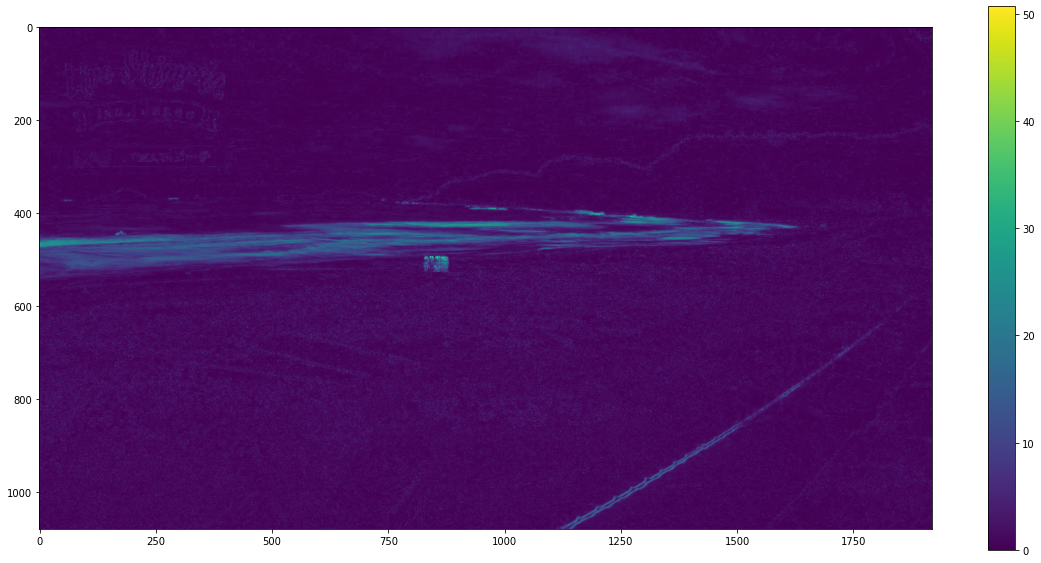

In [ ]:
plt.figure(figsize=(20,10))
im=plt.imshow(greyscale_cube.std(axis=2))
plt.colorbar(im)

#### Next, perform dense optical flow on the gradient to find the primary wave direction

TODO: some comparisons between quality of optical flow on the unnormalized image and on the gradient

In [ ]:
#export
import numpy as np
import cv2

def dense_optical_flow(image_cube, start_idx=0, n_flows=None, step_size=1):
    """xy flow:  X is down, Y is to right in image space
       hsv flow: hue/saturation encode direction, value (magnitude) is in index 2"""
    
    if n_flows is None:
        n_flows = (image_cube.shape[-1] - 1) // step_size
        
    prv_img = image_cube[:,:,start_idx]
    hsv = np.zeros((prv_img.shape[0], prv_img.shape[1], 3), dtype='float32')
    hsv[...,1] = 255
    flows = []
    hsv_flows = []
    for i in range(n_flows):
        next_img = image_cube[:,:,step_size*i + start_idx + step_size]
        flow = cv2.calcOpticalFlowFarneback(prv_img,next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = mag # cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
        hsv_flows.append(rgb)

        prv_img = next_img
        
    xy_flow_cube = np.stack(flows, axis=3)
    hsv_flow_cube = np.stack(hsv_flows, axis=3)
    return xy_flow_cube, hsv_flow_cube


#### Optical flow on raw greyscale  
(Works well even without the scaling)

In [ ]:
xy_cube, hsv_cube = dense_optical_flow(greyscale_cube, start_idx=1, n_flows=20, step_size=2)
print(xy_cube.shape)
print(hsv_cube.shape)

(1080, 1920, 2, 20)
(1080, 1920, 3, 20)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


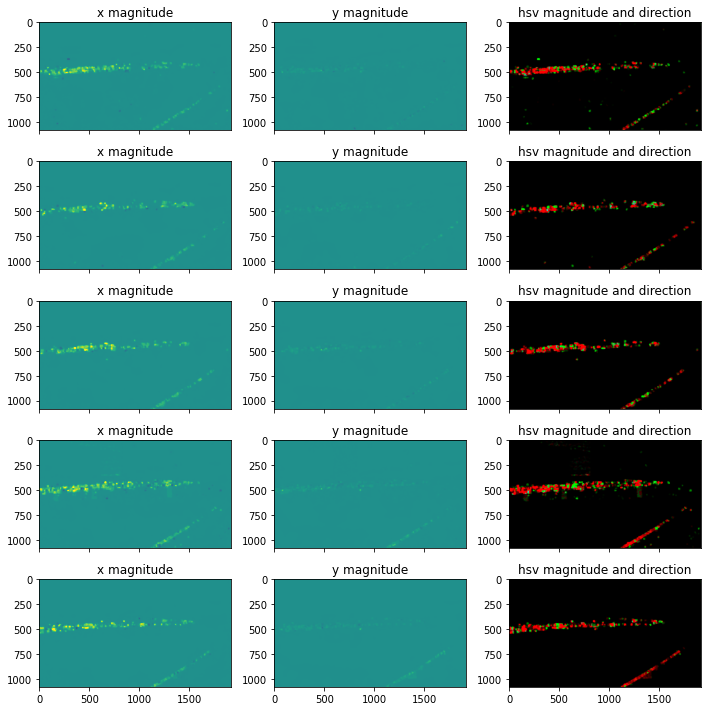

In [ ]:
if xy_cube.shape[-1] > 5:
    pltflows = xy_cube[..., :5]
else:
    pltflows = xy_cube
nrows = pltflows.shape[-1]
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows*2), sharex='all')
for idx in range(nrows):
    axes[idx][0].imshow(pltflows[:,:,0,idx], vmin=-3, vmax=3)
    axes[idx][0].set_title('x magnitude')
    axes[idx][1].imshow(pltflows[:,:,1,idx], vmin=-3, vmax=3)
    axes[idx][1].set_title('y magnitude')
    axes[idx][2].imshow(hsv_cube[:,:,:,idx])
    axes[idx][2].set_title('hsv magnitude and direction')
plt.tight_layout()

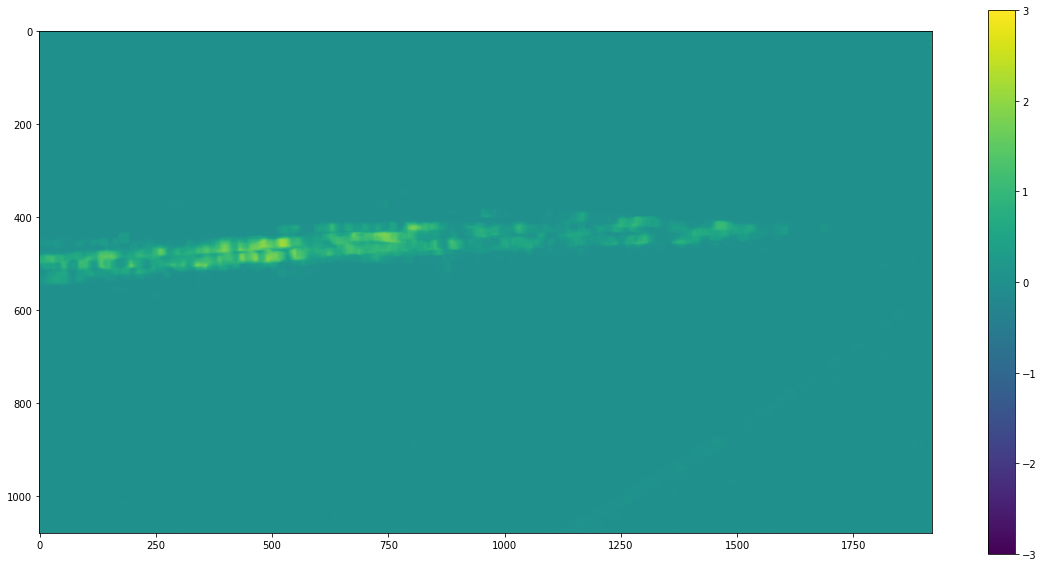

In [ ]:
mean_xflow = xy_cube[:,:,0,:].mean(axis=2)
mean_yflow = xy_cube[:,:,1,:].mean(axis=2)
mean_flow_mag = np.sqrt(mean_yflow*mean_yflow + mean_xflow*mean_xflow)
plt.figure(figsize=(20,10))
im = plt.imshow(mean_flow_mag, vmin=-3, vmax=3)
plt.colorbar(im)
plt.show()

### Perform fit to the heatmap generated by optical flow

In [ ]:
#export
def heatmap_fit(input_heatmap, draw_fit=False):
    """Returns (xrange, yrange) of the best fit to given heatmap"""
    
    frame = input_heatmap

    # setup initial location of window (top-left corner, plus x and y offsets)
    # X is left-to-right, Y is top-to-bottom
    x, y, w, h = 0, 0, frame.shape[1], frame.shape[0] # simply hardcoded the values
    track_window = (x, y, w, h)

    # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
    term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 1 )

    # Define the target heatmap
    prob_image = frame

    # apply camshift to get the new location
    ret, track_window = cv2.CamShift(prob_image, track_window, term_crit)
    
    if draw_fit:
        import matplotlib.pyplot as plt
        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame.copy(),[pts],True, 1,2)
        plt.figure(figsize=(10,5))
        plt.imshow(img2)
        plt.show()

    max_x = max(p[0] for p in pts)
    min_x = max(0, min(p[0] for p in pts))
    max_y = max(p[1] for p in pts)
    min_y = min(p[1] for p in pts)
    
    return (min_x, max_x), (min_y, max_y)

In [ ]:
xy_cube, hsv_cube = dense_optical_flow(greyscale_cube, start_idx=1, 
                                       n_flows=50, step_size=2)
mean_xflow = xy_cube[:,:,0,:].mean(axis=2)
mean_yflow = xy_cube[:,:,1,:].mean(axis=2)
mean_flow_mag = np.sqrt(mean_yflow*mean_yflow + mean_xflow*mean_xflow)

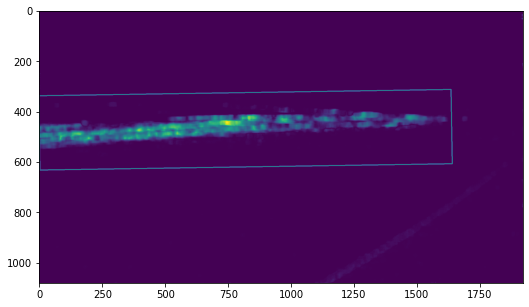

((0, 1639), (311, 631))

In [ ]:
xrange, yrange = heatmap_fit(mean_flow_mag, draw_fit=True)
xrange, yrange

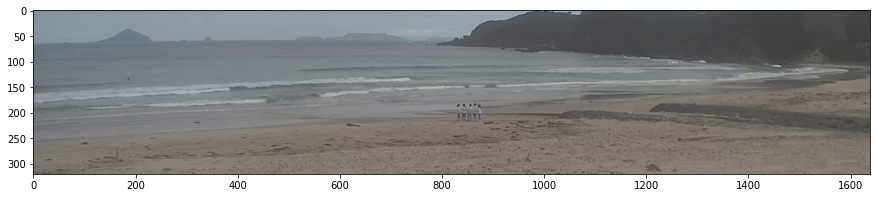

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(frames[0][yrange[0]:yrange[1], xrange[0]:xrange[1]])

In [ ]:
def shift_img(img, xshift, yshift):
    M = np.array([[1.,0.,xshift],[0.,1.,yshift]], dtype='float32')
    out_img = cv2.warpAffine(img, M, dsize=img.T.shape, borderMode=cv2.BORDER_TRANSPARENT)
    return out_img

## Package into a single function to crop and produce an averaged wave vector

In [ ]:
#export
def trim_image(image, xrange, yrange):
    return image[yrange[0]:yrange[1], xrange[0]:xrange[1]]

Decoding ./data/shirahama_1590300962_SURF-101cm.ts  Duration: 2.0m (120.00s)  FPS: 60.0
(outputting one image for every 2 video frames)


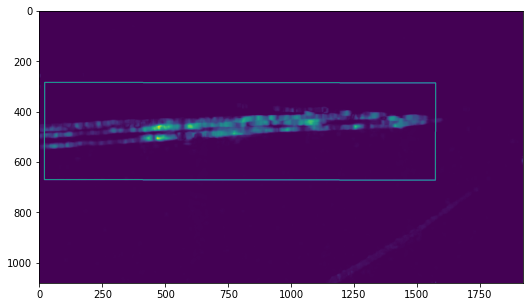

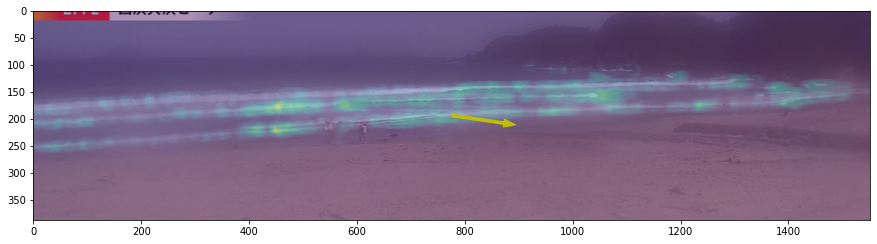

In [ ]:
from surfbreak import load_videos, wave_detection
import matplotlib.pyplot as plt
import numpy as np
import cv2

def test_detection(video_file):
    frames = load_videos.decode_frame_sequence(video_file, duration_s=20, start_s=50, RGB=True,
                                                  one_image_per_n_frames=2)

    greyscale_cube = np.dstack(tuple(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in frames))

    xy_cube, hsv_cube = wave_detection.dense_optical_flow(greyscale_cube, start_idx=1, n_flows=40, step_size=1)

    mean_xflow = xy_cube[:,:,0,:].mean(axis=2)
    mean_yflow = xy_cube[:,:,1,:].mean(axis=2)
    mean_flow_mag = np.sqrt(mean_yflow*mean_yflow + mean_xflow*mean_xflow)

    xrange, yrange = wave_detection.heatmap_fit(mean_flow_mag, draw_fit=True)

    wave_img = wave_detection.trim_image(frames[0], xrange, yrange)

    avg_wave_xdir = wave_detection.trim_image(mean_xflow, xrange, yrange).mean()
    avg_wave_ydir = wave_detection.trim_image(mean_yflow, xrange, yrange).mean()
    wave_vector = (avg_wave_xdir*2000, avg_wave_ydir*2000)

    trimmed_mag = wave_detection.trim_image(mean_flow_mag, xrange, yrange)
    center = ((xrange[1] - xrange[0])//2, (yrange[1] - yrange[0])//2)

    plt.figure(figsize=(15,5))
    plt.imshow(wave_img)
    plt.arrow(center[0], center[1], wave_vector[0], wave_vector[1], color='y', width=5)
    plt.gca().imshow(trimmed_mag, alpha=0.4)

test_detection('./data/shirahama_1590300962_SURF-101cm.ts')

Decoding ./data/shinmaiko_1590370658_SURF-27cm.ts  Duration: 5.0m (300.00s)  FPS: 30.0
(outputting one image for every 2 video frames)


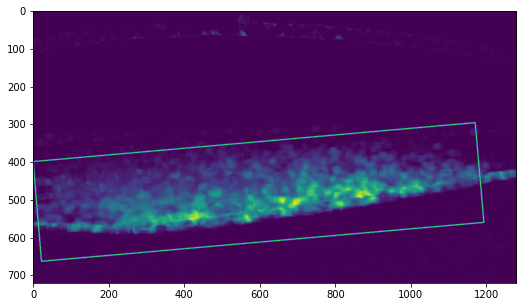

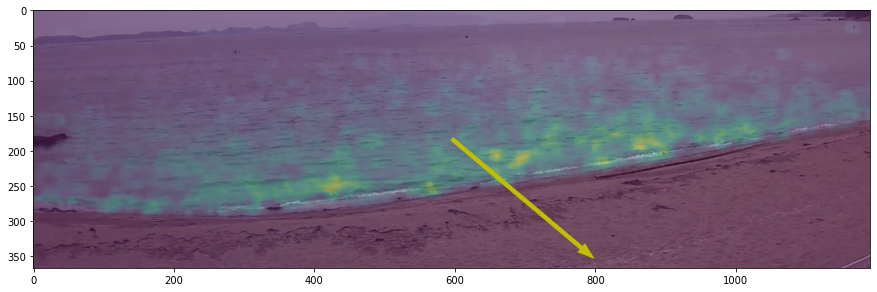

In [ ]:
test_detection('./data/shinmaiko_1590370658_SURF-27cm.ts')

Decoding ./data/shinmaiko_1590480474_SURF-36cm.ts  Duration: 5.0m (300.00s)  FPS: 30.0
(outputting one image for every 2 video frames)


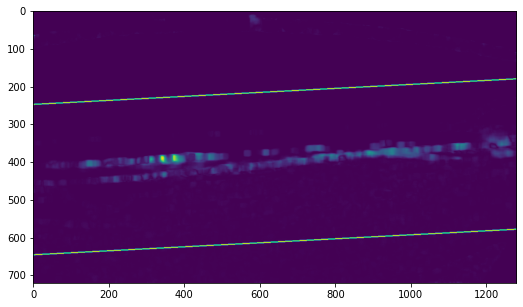

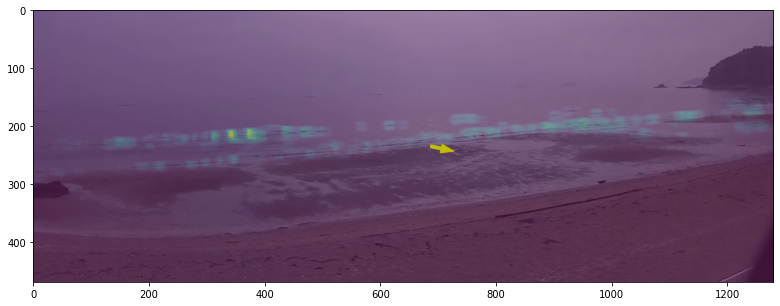

In [ ]:
test_detection('./data/shinmaiko_1590480474_SURF-36cm.ts')

In [ ]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 03_wave_detection.ipynb.
Converted index.ipynb.
